Imagine we have a tile of locations, say "cortical columns" that tile the visual field. 

Each column represents a patch of the full visual space. And each patch encodes the visual features with the same set of sparse filters and code words.



In [1]:
from __future__ import division

from pylab import *
import scipy
import time

import imnet_utils as imut
import sklearn
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, NMF

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'text.usetex': True})

In [2]:
def norm_range(v):
    return (v-v.min())/(v.max()-v.min())

In [4]:
reload(imut)
patch_size=(10,10)
tstart = time.time()
impatches = imut.load_random_imnet_patches(100000, patch_size=patch_size)
print "Duration: ", time.time() - tstart


0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 Duration:  65.6522760391


In [5]:
import glob

im_list = glob.glob('data/image_net/*')
print len(im_list)

12226


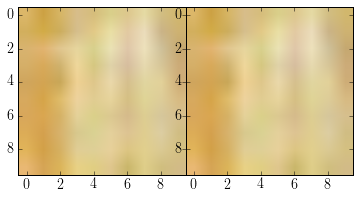

In [29]:
impatchr = impatches.copy().reshape((-1, impatches.shape[3]))

impatchr -= 1
impatchr /= 255



irec = impatchr[:, 22].reshape((impatches.shape[0], impatches.shape[1], impatches.shape[2]))

subplot(121)
imshow((impatches[:,:,:,22]-1)/255)
subplot(122)
imshow(irec)

In [7]:
impatchr -= impatchr.mean(axis=1)[:, np.newaxis]


In [30]:
mean01 = impatchr.mean()

In [31]:
impatchr -= impatchr.mean()

In [32]:

ncomponents = min(300, patch_size[0]*patch_size[1]*3-1)

pca_encoder = TruncatedSVD(ncomponents)
fica_encoder = FastICA(ncomponents)



In [33]:
tstart = time.time()
pca_encoder.fit(impatchr.T)
print 'Duration: ', time.time() - tstart


Duration:  22.7080721855


In [34]:
scores = pca_encoder.transform(impatchr.T)

In [35]:
pc_comp = pca_encoder.components_

print pc_comp.shape

pc_comp_ims = pc_comp.T.reshape((impatches.shape[0], impatches.shape[1], impatches.shape[2], -1))

(299, 300)


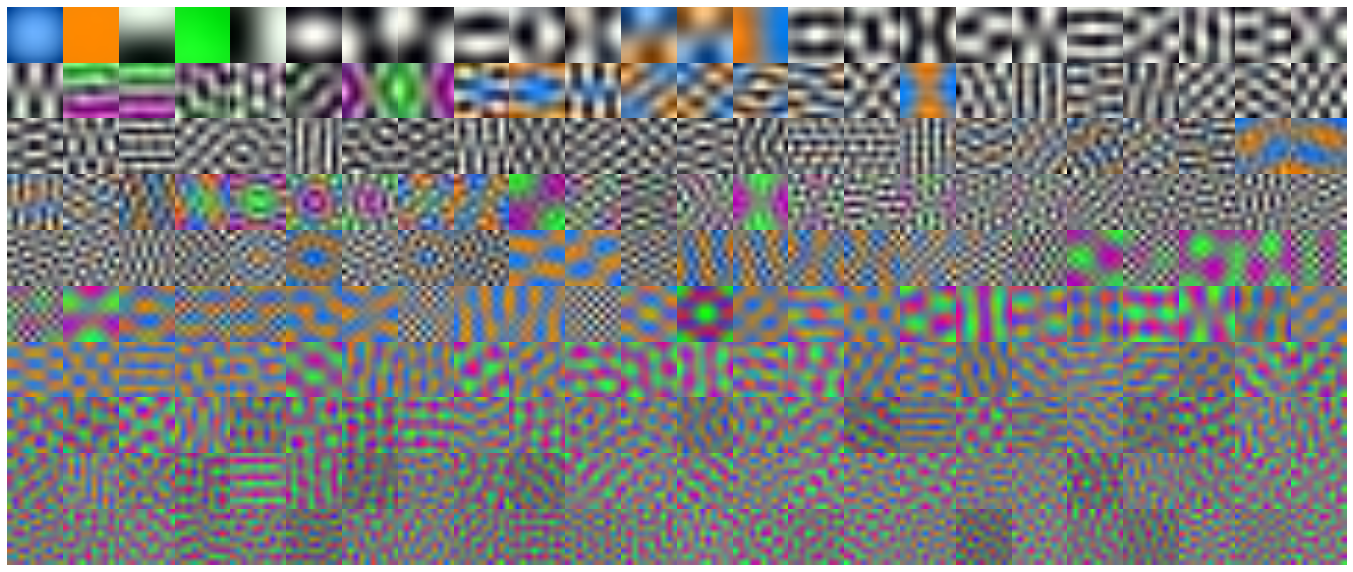

In [36]:
plt.rcParams['figure.subplot.hspace'] = 0
plt.rcParams['figure.subplot.wspace'] = 0

figure(figsize=(24,10))

nshow = 240
maxrow = 24
for i in range(nshow):
    ax=subplot(nshow//maxrow,maxrow,i+1)
    imshow(norm_range(pc_comp_ims[:,:,:,i]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)


In [37]:
tstart = time.time()
which_pcs = np.arange(240)
fica_encoder.fit(scores[:,which_pcs])
print 'Duration: ', time.time() - tstart


n_components is too large: it will be set to 240
Duration:  180.443974972


In [38]:
ic_scores = fica_encoder.transform(scores[:1000,which_pcs])

In [39]:
pc_scores = scores[:ic_scores.shape[0], :ic_scores.shape[1]]


In [40]:
ic_comp = fica_encoder.components_
ic_comp /= ic_comp.std(axis=0)
ic_comp = np.dot(ic_comp, pc_comp[which_pcs,:])
print ic_comp.shape

(240, 300)


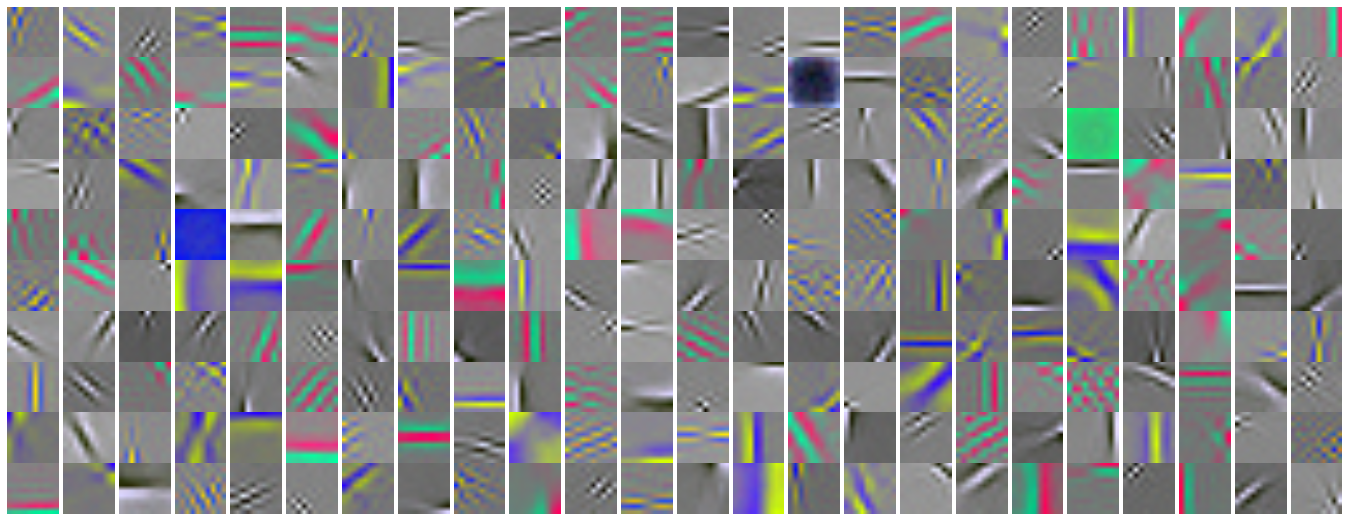

In [41]:
ic_comp_ims = ic_comp.T.reshape((impatches.shape[0], impatches.shape[1], impatches.shape[2], -1))
figure(figsize=(24,10))
nshow = min(len(which_pcs), 240)
maxrow = 24
for i in range(nshow):
    ax=subplot(nshow//maxrow+1,maxrow,i+1)
    imshow(norm_range(ic_comp_ims[:,:,:,i+0]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)


In [42]:
nrecon = 16
impatch = imut.load_random_imnet_patches(nrecon, patch_size)
#impatch = impatches[:,:,:,58]
impatchr = impatch.reshape((-1, nrecon))
#impatchr -= impatchr.mean(axis=1)[:, np.newaxis]
impatchr -= impatchr.mean()

ic_c = linalg.lstsq(ic_comp.T, impatchr)
pc_c = linalg.lstsq(pc_comp[which_pcs,:].T, impatchr)
ic_code = ic_c[0].T
pc_code = pc_c[0].T

0


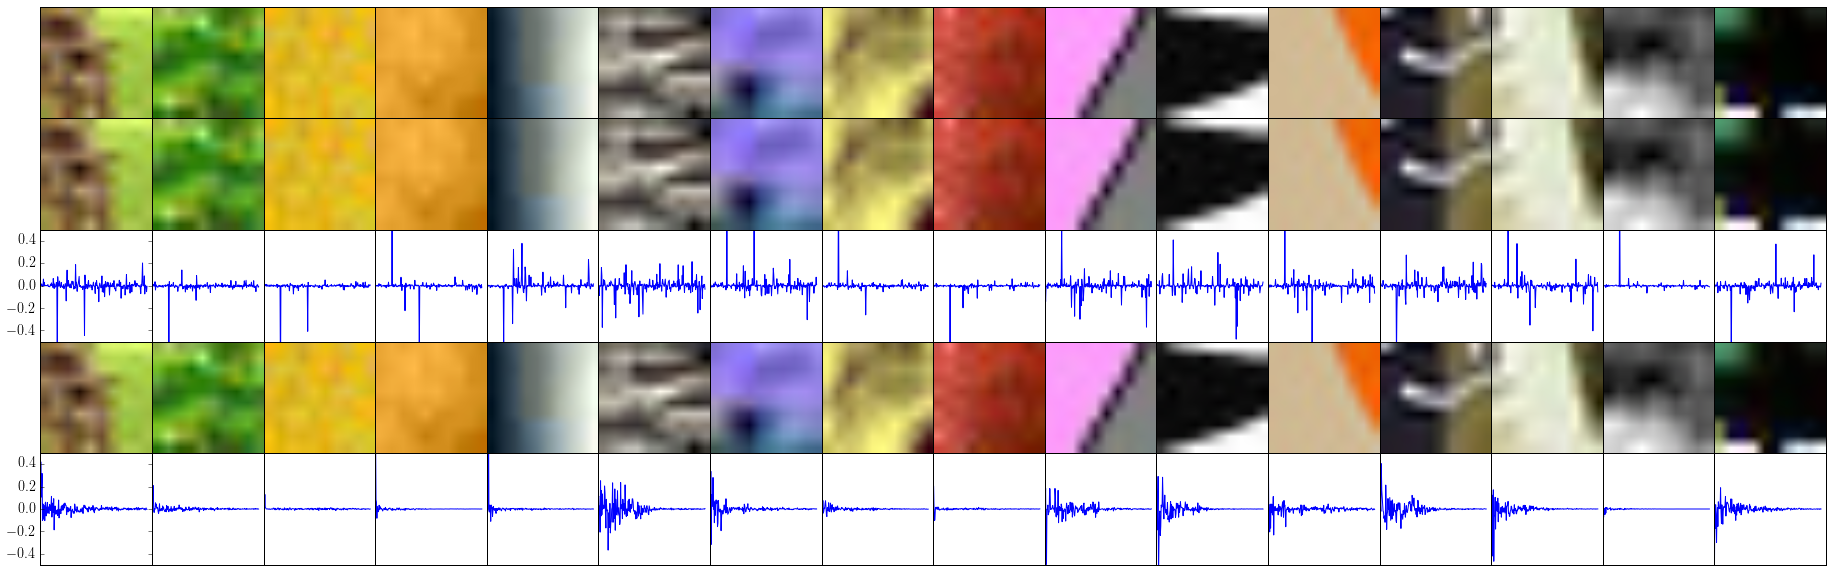

In [43]:


figure(figsize=(32, 10))

for imx in range(nrecon):
    
    ax = subplot(5, nrecon, imx + 1)
    imp = impatchr[:,imx].reshape(patch_size[0], patch_size[1], 3)
    imshow(norm_range(imp))
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = subplot(5, nrecon, imx + 1 + nrecon)
    ic_recon = np.dot(ic_code[imx,:], ic_comp)
    ic_reconr = ic_recon.reshape(patch_size[0], patch_size[1], 3)
    imshow(norm_range(ic_reconr))
    ax.set_xticks([])
    ax.set_yticks([])
    
    
    ax = subplot(5, nrecon, imx + 1 + 2*nrecon)
    plot(ic_code[imx,:].T/norm(ic_code[imx, :]))
    ax.set_xticks([])
    ax.set_ylim([-0.5, 0.5])
    if imx > 0:
        ax.set_yticks([])

    ax = subplot(5, nrecon, imx + 1 + 3*nrecon)
    pc_recon = np.dot(pc_code[imx,:], pc_comp[which_pcs,:])
    pc_reconr = pc_recon.reshape(patch_size[0], patch_size[1], 3)
    imshow(norm_range(pc_reconr))
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = subplot(5, nrecon, imx + 1 + 4*nrecon)
    plot(pc_code[imx,:].T/norm(pc_code[imx, :]))
    ax.set_xticks([])
    ax.set_ylim([-0.5, 0.5])
    if imx > 0:
        ax.set_yticks([])


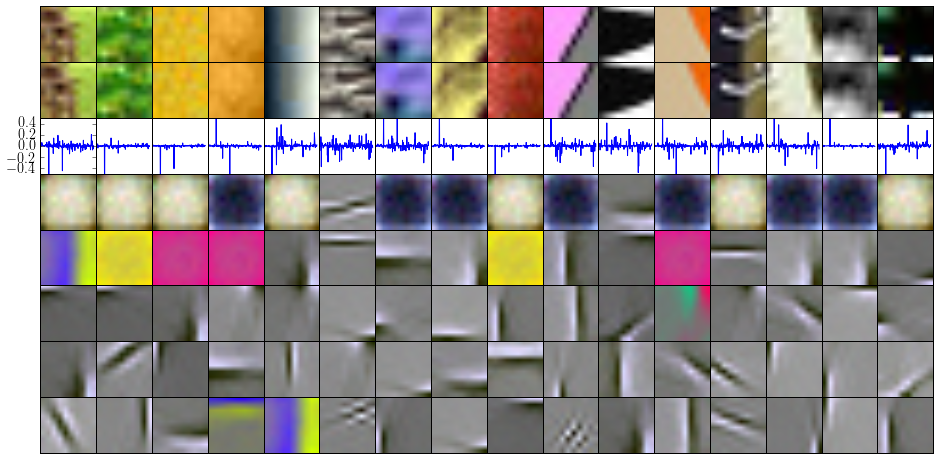

In [44]:
figure(figsize=(16, 8))

ic_ex = 2*arange(5)+1
nrows = 3 + len(ic_ex)
for imx in range(nrecon):
    
    ax = subplot(nrows, nrecon, imx + 1)
    imp = impatchr[:,imx].reshape(patch_size[0], patch_size[1], 3)
    imshow(norm_range(imp))
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = subplot(nrows, nrecon, imx + 1 + nrecon)
    ic_recon = np.dot(ic_code[imx,:], ic_comp)
    ic_reconr = ic_recon.reshape(patch_size[0], patch_size[1], 3)
    imshow(norm_range(ic_reconr))
    ax.set_xticks([])
    ax.set_yticks([])
    
    
    ax = subplot(nrows, nrecon, imx + 1 + 2*nrecon)
    plot(ic_code[imx,:].T/norm(ic_code[imx, :]))
    ax.set_xticks([])
    ax.set_ylim([-0.5, 0.5])
    if imx > 0:
        ax.set_yticks([])

          
    idx_max = np.argsort(abs(ic_code[imx,:]))
  
    for ici,icx in enumerate(ic_ex):
        ax = subplot(nrows, nrecon, imx + 1 + (3+ici)*nrecon)
        ic_compr = ic_comp[idx_max[-icx],:].reshape(patch_size[0], patch_size[1], 3) 
        ic_compr = ic_compr * ic_code[imx, idx_max[-icx]] # this just flips it if its negative
        imshow(norm_range(ic_compr))
        ax.set_xticks([])
        ax.set_yticks([])
    


In [45]:
def draw_ic_im(ic_coef, ic_comps, nx, ny, patch_size):
    im = np.zeros((int(nx*patch_size[0]), int(ny*patch_size[1]), 3))
    
    cfx = 0
    for ix in range(nx):
        for iy in range(ny):
            ic_recon = np.dot(ic_coef[cfx], ic_comps)
            ic_reconr = ic_recon.reshape(patch_size[0], patch_size[1], 3)
            
            ic_reconr = (ic_reconr + mean01)
            
            ic_reconr[ic_reconr<0] = 0 
            ic_reconr[ic_reconr>1] = 1
            
            
            im[ix*patch_size[0]:(ix+1)*patch_size[0], 
                      iy*patch_size[1]:(iy+1)*patch_size[1], :] = ic_reconr #norm_range(ic_reconr)
            cfx+=1
            
    return im


## FHRR images

In [46]:
def fhrr_vec(D, N):
    # pick a random phase
    rphase = 2 * np.pi * np.random.rand(D, N // 2)

    fhrrv = np.zeros((D, 2 * (N//2)))
    fhrrv[:, :(N//2)] = np.cos(rphase)
    fhrrv[:, (N//2):] = np.sin(rphase)
    
    return fhrrv

def fhrr_inv(a):
    N2 = a.shape[1] // 2
    b = np.zeros_like(a)
    b[:,:N2] = a[:, :N2]
    b[:,N2:] = -a[:, N2:]
    
    return b

def fhrr_bind(a, b, pa=1, pb=1):
    # we want to do element wise multiply of complex numbers
    N2 = a.shape[1] // 2
    
    
    if not pa==1:
        a = fhrr_pow(a, pa)
        
    if not pb==1:
        b = fhrr_pow(b, pb)
  
    ra = a[:, :N2]
    ia = a[:, N2:]
    rb = b[:, :N2]
    ib = b[:, N2:]
              
    c = np.zeros_like(a)
    
    c[:, :N2] = ra * rb - ia * ib
    c[:, N2:] = ra * ib + rb * ia
    
    return c
 
    
def fhrr_pow(a, pa=1):
    N2 = a.shape[1] // 2
    
    ra = a[:, :N2]
    ia = a[:, N2:]
    
    if not pa == 1:
        ma = (ra**2 + ia**2) ** (pa/2) 
        aa = pa * (np.arctan(ia/ra) + (ra < 0) * np.pi)
        ra = ma * np.cos(aa)
        ia = ma * np.sin(aa)
        
    c = np.zeros_like(a)
    c[:, :N2] = ra
    c[:, N2:] = ia
    
    return c
    
def fhrr_roll(a, r=1):
    N2 = a.shape[1] // 2
    c = np.zeros_like(a)
    c[:, :N2] = np.roll(a[:, :N2], r, axis=1)
    c[:, N2:] = np.roll(a[:, N2:], r, axis=1)
    
    return c

def fhrr_cc(a, b):
    
    pass
    

In [98]:
def sparsify(x, tau=1):
    return 0.5*tau*(np.exp(x/tau) - np.exp(-x/tau))

In [63]:
N=100000
icD = len(which_pcs)
ic_hyperpatch = fhrr_vec(icD, N)

nx_patch = 5
ny_patch = 5

loc_hyperbase = fhrr_vec(2, N) #2*(np.random.randn(2, N) < 0) - 1

code_vecs = []

for ix in range(nx_patch):
    for iy in range(ny_patch):
        
        code_v = fhrr_bind(loc_hyperbase[[0],:], loc_hyperbase[[1],:], pa=(ix+1), pb=(iy+1))
        #code_v = fhrr_bind(fhrr_roll(loc_hyperbase[[0],:], ix+1), 
        #                   fhrr_roll(loc_hyperbase[[1],:], iy+1))
        ic_code = fhrr_bind(np.tile(code_v, (icD, 1)), ic_hyperpatch)
        
        code_vecs.append(ic_code)
        

In [49]:
nrecon = 16
big_patch_size = (patch_size[0] * nx_patch, patch_size[1] * ny_patch)

impatch = imut.load_random_imnet_patches(nrecon, big_patch_size)



0


In [50]:
mean01

0.44874641215686317

In [51]:
#

ic_im_vecs = []

for ix in range(nx_patch):
    for iy in range(ny_patch):
        imp = impatch[ix*patch_size[0]:(ix+1)*patch_size[0], 
                      iy*patch_size[1]:(iy+1)*patch_size[1], :]
        impatchr = imp.reshape((-1, nrecon)).copy()
        impatchr = (impatchr-1)/255
        #impatchr -= impatchr.mean(axis=1)[:, np.newaxis]
        impatchr -= mean01

        ic_c = linalg.lstsq(ic_comp.T, impatchr)
        ic_code = ic_c[0].T
        ic_im_vecs.append(ic_code)
        

In [305]:
impatch.max()

256.0

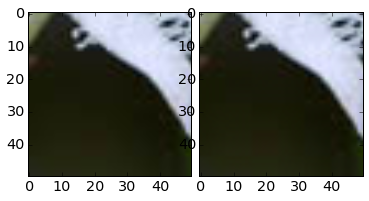

In [58]:
im_idx = 12
icima = np.array(ic_im_vecs)
subplot(121)
imshow(257-impatch[:,:,:,im_idx])
subplot(122)
imshow(draw_ic_im(icima[:,im_idx,:], ic_comp, nx_patch, ny_patch, patch_size))


In [129]:
n_steps = 8

cc_states = []
cc_hist = []
#resonances = []
#eignorm = 1
#obj_resonance = np.dot(np.dot(pinv(obj_vecs), eignorm * np.eye(objD)), obj_vecs)

bound_imvec = np.zeros(N)
cv_inv = []

for iCC in range(len(code_vecs)):
    cc_s = np.random.randn(N)
    cc_h = np.zeros((n_steps, icD))
    
    cv_inv.append(pinv(code_vecs[iCC]))
    imv = np.dot(ic_im_vecs[iCC][im_idx, :], code_vecs[iCC])
    
    bound_imvec += imv
    
    cc_states.append(cc_s)
    cc_hist.append(cc_h)
    eignorm = 1
    #res = np.dot(np.dot(pinv(code_vecs[iCC]), eignorm * np.eye(icD)), code_vecs[iCC])
    #resonances.append(res)
    
bound_imvec = fhrr_bind(fhrr_bind(bound_imvec[np.newaxis], loc_hyperbase[[0],:], pb=0), loc_hyperbase[[1],:], pb=0)
thal_vec = np.zeros(N)

for i in range(n_steps):
    thal_vec[:] = bound_imvec
    #thal_vec[:] = fhrr_bind(thal_vec[np.newaxis], loc_hyperbase[[1],:], pb=0)
    for iCC in range(len(code_vecs)):
        cc_hist[iCC][i,:] = np.dot(code_vecs[iCC]/N, cc_states[iCC]) 
        
        thal_vec -= cc_states[iCC]
        
    for iCC in range(len(code_vecs)):
        cc_upd = np.dot(code_vecs[iCC]/N, thal_vec)
        ncc = np.linalg.norm(cc_upd)
        cc_upd = sparsify(cc_upd/ncc, 0.1)
        cc_upd = ncc * cc_upd/np.linalg.norm(cc_upd)
        
        cc_states[iCC] += np.dot(cc_upd, code_vecs[iCC]) # + 0.5*np.random.randn(N) #np.dot(cv_inv[iCC], cc_upd)
        #cc_states[iCC] = np.dot(cv_inv[iCC], cc_hist[iCC][i,:]) #np.dot(cc_hist[iCC][i,:], code_vecs[iCC])
        #cc_states[iCC] = np.dot(resonances[iCC], thal_vec+cc_states[iCC])
 

In [130]:
cc_hista = np.array(cc_hist)

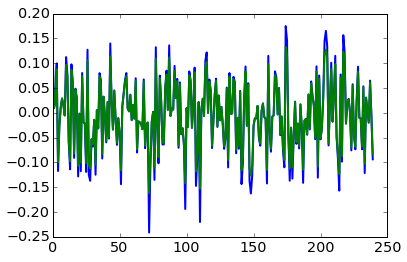

In [131]:
plot(sparsify(cc_upd/ncc, 0.1), lw=2)
plot(cc_upd/ncc, lw=2)


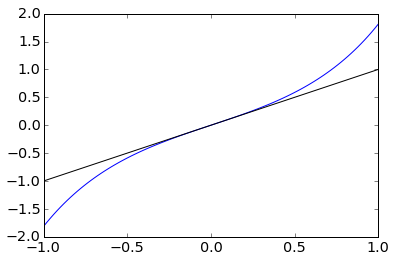

In [132]:
x = linspace(-1, 1,100)
y = sparsify(x, 0.5)
plot(x,y)
plot(x,x,'k')

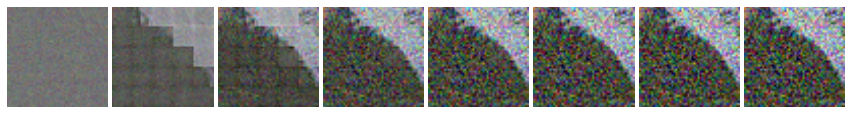

In [133]:
plt.rcParams['figure.subplot.hspace'] = 0
plt.rcParams['figure.subplot.wspace'] = .05

figure(figsize=(15,8))

maxrow = 8
nshow= 8


for i in range(nshow):
    ax=subplot(nshow//maxrow+1,maxrow,i+1)
    
    im = draw_ic_im((cc_hista[:, i, :]), ic_comp, nx_patch, ny_patch, patch_size)
    imshow(im)    
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)




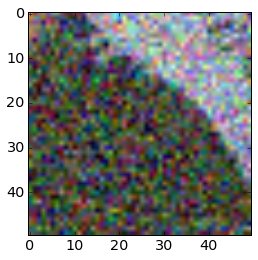

In [134]:
imshow(draw_ic_im(cc_hista[:,-1,:], ic_comp, nx_patch, ny_patch, patch_size))

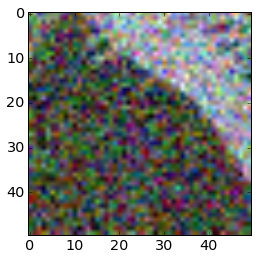

In [106]:
imshow(draw_ic_im(cc_hista[:,-1,:], ic_comp, nx_patch, ny_patch, patch_size))

## Texture 



In [136]:
n_steps = 8

cc_states = []
cc_hist = []
#resonances = []
#eignorm = 1
#obj_resonance = np.dot(np.dot(pinv(obj_vecs), eignorm * np.eye(objD)), obj_vecs)

bound_imvec = np.zeros(N)
cv_inv = []

for iCC in range(len(code_vecs)):
    cc_s = np.random.randn(N)
    cc_h = np.zeros((n_steps, icD))
    
    cv_inv.append(pinv(code_vecs[iCC]))
    imv = np.dot(ic_im_vecs[iCC][im_idx, :], code_vecs[iCC])
    
    bound_imvec += imv
    
    cc_states.append(cc_s)
    cc_hist.append(cc_h)
    eignorm = 1
    #res = np.dot(np.dot(pinv(code_vecs[iCC]), eignorm * np.eye(icD)), code_vecs[iCC])
    #resonances.append(res)
    
bound_imvec = fhrr_bind(fhrr_bind(bound_imvec[np.newaxis], loc_hyperbase[[0],:], pb=0), loc_hyperbase[[1],:], pb=0)
thal_vec = np.zeros(N)

for i in range(n_steps):
    thal_vec[:] = bound_imvec
    #thal_vec[:] = fhrr_bind(thal_vec[np.newaxis], loc_hyperbase[[1],:], pb=0)
    for iCC in range(len(code_vecs)):
        cc_hist[iCC][i,:] = np.dot(code_vecs[iCC]/N, cc_states[iCC]) 
        
        thal_vec -= cc_states[iCC]
        
    for iCC in range(len(code_vecs)):
        cc_upd = np.dot(code_vecs[iCC]/N, thal_vec)
        #ncc = np.linalg.norm(cc_upd)
        #cc_upd = sparsify(cc_upd/ncc, 0.1)
        #cc_upd = ncc * cc_upd/np.linalg.norm(cc_upd)
        
        cc_states[iCC] += np.dot(cc_upd, code_vecs[iCC]) # + 0.5*np.random.randn(N) #np.dot(cv_inv[iCC], cc_upd)
        #cc_states[iCC] = np.dot(cv_inv[iCC], cc_hist[iCC][i,:]) #np.dot(cc_hist[iCC][i,:], code_vecs[iCC])
        #cc_states[iCC] = np.dot(resonances[iCC], thal_vec+cc_states[iCC])
cc_hista = np.array(cc_hist)

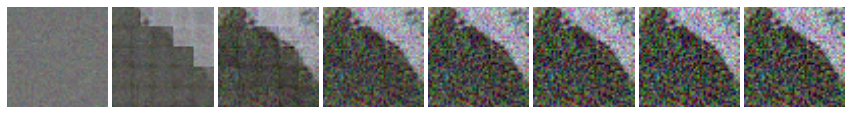

In [138]:
plt.rcParams['figure.subplot.hspace'] = 0
plt.rcParams['figure.subplot.wspace'] = .05

figure(figsize=(15,8))

maxrow = 8
nshow =8

for i in range(nshow):
    ax=subplot(nshow//maxrow+1,maxrow,i+1)
    
    im = draw_ic_im((cc_hista[:, i, :]), ic_comp, nx_patch, ny_patch, patch_size)
    imshow(im)    
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)




## Translation

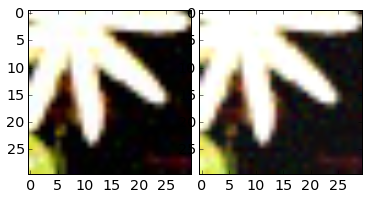

In [66]:
im_idx = 3
icima = np.array(ic_im_vecs)
subplot(121)
imshow(257-impatch[:,:,:,im_idx])
subplot(122)
imshow(draw_ic_im(255*icima[:,im_idx,:], ic_comp, nx_patch, ny_patch, patch_size))


In [281]:
n_steps = 16

cc_states = []
cc_hist = []
#resonances = []
#eignorm = 1
#obj_resonance = np.dot(np.dot(pinv(obj_vecs), eignorm * np.eye(objD)), obj_vecs)

bound_imvec = np.zeros(N)
cv_inv = []

for iCC in range(len(code_vecs)):
    cc_s = np.random.randn(N)
    cc_h = np.zeros((n_steps, icD))
    
    cv_inv.append(pinv(code_vecs[iCC]))
    imv = np.dot(ic_im_vecs[iCC][im_idx, :], code_vecs[iCC])
    
    bound_imvec += imv
    
    cc_states.append(cc_s)
    cc_hist.append(cc_h)
    eignorm = 1
    #res = np.dot(np.dot(pinv(code_vecs[iCC]), eignorm * np.eye(icD)), code_vecs[iCC])
    #resonances.append(res)
    
thal_vec = np.zeros(N)

for i in range(n_steps):
    thal_vec[:] = bound_imvec
    thal_vec[:] = fhrr_bind(thal_vec[np.newaxis], loc_hyperbase[[1],:], pb=-1)
    for iCC in range(len(code_vecs)):
        cc_hist[iCC][i,:] = np.dot(code_vecs[iCC]/N, cc_states[iCC]) 
        
        thal_vec -= cc_states[iCC]
        
    for iCC in range(len(code_vecs)):
        cc_upd = np.dot(code_vecs[iCC]/N, thal_vec)
        cc_states[iCC] += np.dot(cc_upd, code_vecs[iCC]) # + 0.5*np.random.randn(N) #np.dot(cv_inv[iCC], cc_upd)
        #cc_states[iCC] = np.dot(cv_inv[iCC], cc_hist[iCC][i,:]) #np.dot(cc_hist[iCC][i,:], code_vecs[iCC])
        #cc_states[iCC] = np.dot(resonances[iCC], thal_vec+cc_states[iCC])
 

In [285]:
cc_hista = np.array(cc_hist)

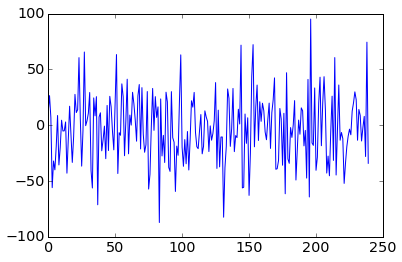

In [97]:
plot(cc_upd*N)

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


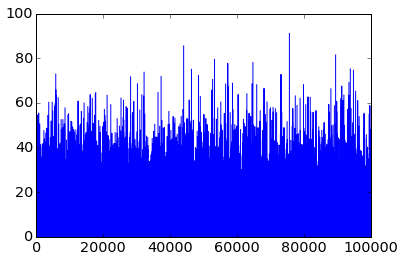

In [74]:
plot(thal_vec**1.5)

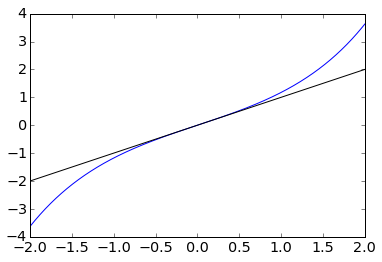

In [94]:
x = np.linspace(-2, 2, 1500)
tau=1
y = 0.5*tau*(np.exp(x/tau) - np.exp(-x/tau))

plot(x,y)
plot(x,x,'k')

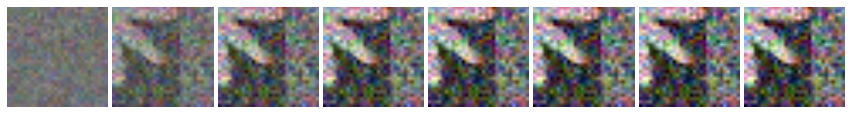

In [289]:
plt.rcParams['figure.subplot.hspace'] = 0
plt.rcParams['figure.subplot.wspace'] = .05

figure(figsize=(15,8))

maxrow = 8
nshow =8

for i in range(nshow):
    ax=subplot(nshow//maxrow+1,maxrow,i+1)
    
    im = draw_ic_im((cc_hista[:, i, :]), ic_comp, nx_patch, ny_patch, patch_size)
    imshow(im)    
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)




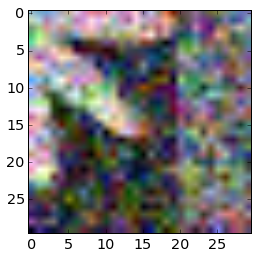

In [290]:
imshow(draw_ic_im(cc_hista[:,-1,:], ic_comp, nx_patch, ny_patch, patch_size))

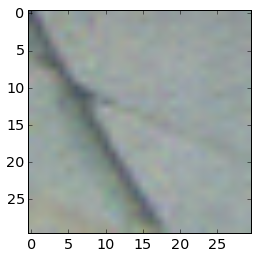

In [67]:
imshow(draw_ic_im(cc_hista[:,i,:]/N, ic_comp, nx_patch, ny_patch, patch_size))

-47.5823955684 37.3377387116
-55.8934254273 22.8238666751
-40.723113386 25.0059925971
-39.8630182901 39.6721118156
-37.2242538313 38.345535738
-47.336182546 34.8831247045
-54.7304532923 -6.0795225052
-58.8654359431 13.9044906167
-41.0941676089 20.5160826302


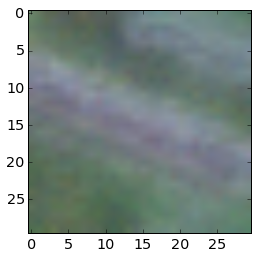

In [45]:
imshow(draw_ic_im(cc_hista[:,i,:]/N, ic_comp, nx_patch, ny_patch, patch_size))

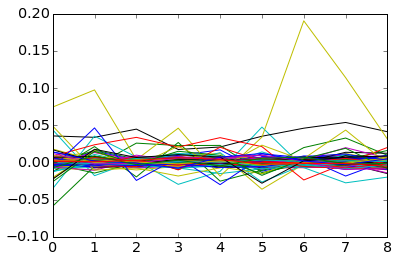

In [37]:
plot(cc_hista[:,1,:]/N/255);

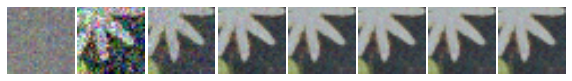

In [62]:
plt.rcParams['figure.subplot.hspace'] = 0
plt.rcParams['figure.subplot.wspace'] = .05

figure(figsize=(10,8))

maxrow = 8
nshow =8

for i in range(nshow):
    ax=subplot(nshow//maxrow+1,maxrow,i+1)
    
    im = draw_ic_im(255*cc_hista[:, i, :]/N, ic_comp, nx_patch, ny_patch, patch_size)
    imshow(im)    
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)




In [57]:
code_vecs[0].shape

(150, 15000)

In [58]:
cc_hist[0].shape

(10, 150)

In [51]:
n_steps = 10

cc_states = []
cc_hist = []
resonances = []
#eignorm = 1
#obj_resonance = np.dot(np.dot(pinv(obj_vecs), eignorm * np.eye(objD)), obj_vecs)

bound_imvec = np.zeros(N)

for iCC in range(len(code_vecs)):
    cc_s = np.random.randn(N)
    cc_h = np.zeros((n_steps, icD))
    
    imv = np.dot(ic_im_vecs[iCC][im_idx, :], code_vecs[iCC])
    
    bound_imvec += imv
    
    cc_states.append(cc_s)
    cc_hist.append(cc_h)
    eignorm = 1
    res = np.dot(np.dot(pinv(code_vecs[iCC]), eignorm * np.eye(icD)), code_vecs[iCC])
    resonances.append(res)
    
thal_vec = bound_imvec.copy()

for i in range(n_steps):
    thal_vec[:] = bound_imvec
    for iCC in range(len(code_vecs)):
        cc_hist[iCC][i,:] = np.dot(code_vecs[iCC], cc_states[iCC])
        
        thal_vec -= cc_states[iCC]
        
    for iCC in range(len(code_vecs)):
        
        cc_states[iCC] = np.dot(resonances[iCC], thal_vec+cc_states[iCC])
 

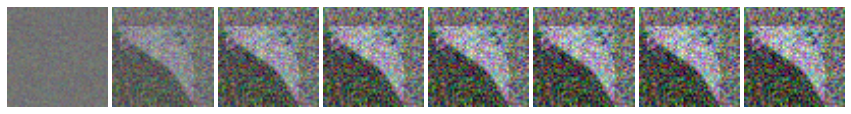

In [71]:
plt.rcParams['figure.subplot.hspace'] = 0
plt.rcParams['figure.subplot.wspace'] = .05

figure(figsize=(15,8))

maxrow = 8
nshow= 8


for i in range(nshow):
    ax=subplot(nshow//maxrow+1,maxrow,i+1)
    
    im = draw_ic_im((cc_hista[:, i, :]), ic_comp, nx_patch, ny_patch, patch_size)
    imshow(im)    
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)




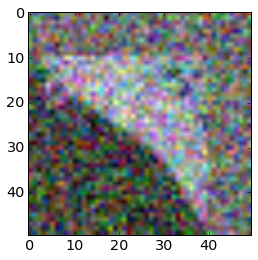

In [72]:
imshow(draw_ic_im(cc_hista[:,-1,:], ic_comp, nx_patch, ny_patch, patch_size))